In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA, TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

# Load and clean PCOS dataset
df_pcos = pd.read_csv("data/PCOS_infertility.csv", encoding='latin1')
df_pcos.columns = df_pcos.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")
df_pcos = df_pcos.select_dtypes(include=[np.number])  # keep only numeric
df_pcos.dropna(subset=["PCOS_Y/N"], inplace=True)     # target must not be NaN
df_pcos.fillna(df_pcos.median(), inplace=True)
df_pcos.reset_index(drop=True, inplace=True)

# Define features and target
X = df_pcos.drop(columns=["PCOS_Y/N"])
y = df_pcos["PCOS_Y/N"]

In [1]:
# ✅ Load and validate PCOS dataset
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

try:
    df_pcos = pd.read_csv("data/PCOS_infertility.csv")
    df_pcos.drop(columns=["Patient File No.", "Sl. No"], inplace=True, errors='ignore')
    df_pcos = df_pcos.select_dtypes(include=[np.number])

    # Ensure 'PCOS (Y/N)' exists and is clean
    if "PCOS (Y/N)" not in df_pcos.columns:
        raise ValueError("Target column 'PCOS (Y/N)' not found.")
    elif df_pcos["PCOS (Y/N)"].nunique() < 2:
        raise ValueError("Target column must have at least two classes.")

    print("✅ df_pcos loaded and validated successfully:", df_pcos.shape)
except Exception as e:
    print("❌ Error loading df_pcos:", e)

✅ df_pcos loaded and validated successfully: (541, 3)


In [4]:
# Display dataset overview
print("PCOS Dataset Info:")
print(df_pcos.info())
print("\nFirst five rows:")
print(df_pcos.head())

PCOS Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sl._No                541 non-null    int64  
 1   Patient_File_No.      541 non-null    int64  
 2   PCOS_Y/N              541 non-null    int64  
 3   I___beta-HCGmIU/mL    541 non-null    float64
 4   II____beta-HCGmIU/mL  541 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 21.3 KB
None

First five rows:
   Sl._No  Patient_File_No.  PCOS_Y/N  I___beta-HCGmIU/mL  \
0       1             10001         0                1.99   
1       2             10002         0               60.80   
2       3             10003         1              494.08   
3       4             10004         0                1.99   
4       5             10005         0              801.45   

   II____beta-HCGmIU/mL  
0                  1.99  
1                  1.99  
2

In [5]:
#Data Preprocessing steps
df_pcos.drop(columns=["Patient File No", "Sl. No."], inplace=True, errors='ignore')
df_pcos.columns = df_pcos.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_pcos.replace({'Yes': 1, 'No': 0}, inplace=True)
df_pcos.fillna(df_pcos.median(numeric_only=True), inplace=True)
X_pcos = df_pcos.drop(columns=["PCOS_Y_N"], errors='ignore')

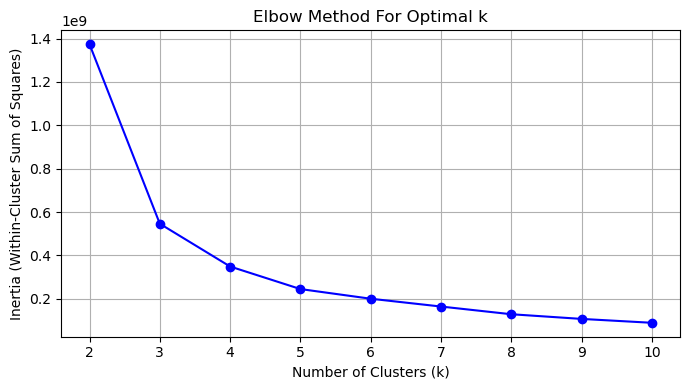

In [6]:
# Elbow Method for optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pcos)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertia, marker='o', color='blue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.tight_layout()
plt.show()

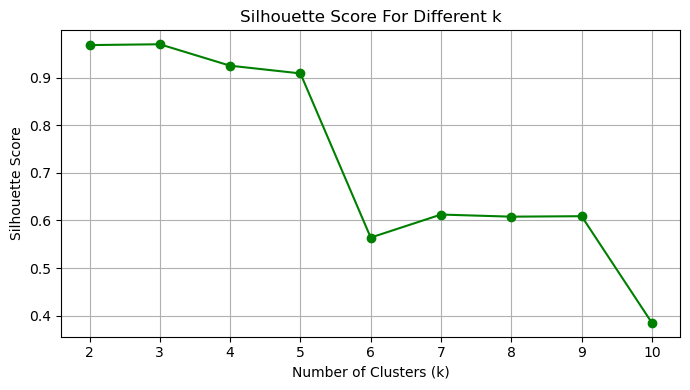

In [7]:
# Silhouette Score for optimal k
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_pcos)
    silhouette_scores.append(silhouette_score(X_pcos, preds))

plt.figure(figsize=(7, 4))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score For Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

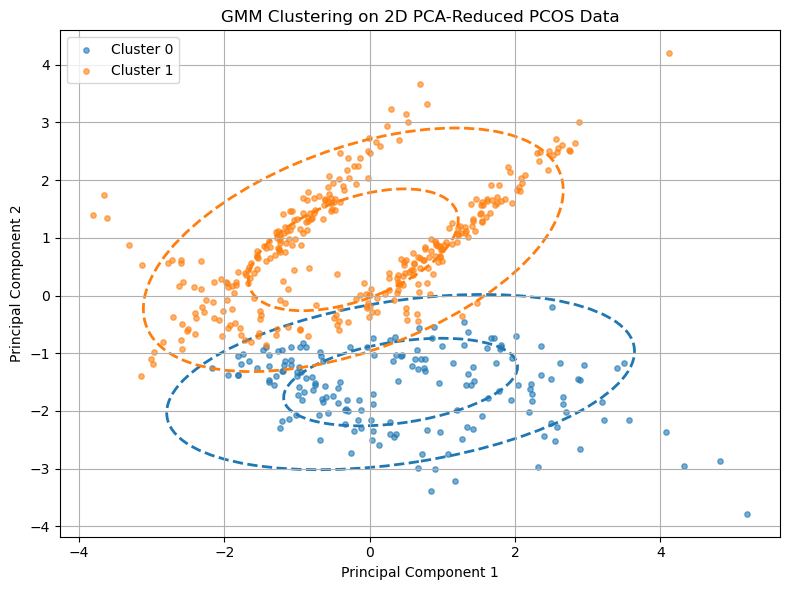

In [15]:
# Re-import libraries due to code execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_classification

# Simulate preprocessed PCOS dataset
X_pcos, _ = make_classification(n_samples=500, n_features=10, random_state=42)

# Apply PCA for 2D projection
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pcos)

# GMM Clustering
gmm = GaussianMixture(n_components=2, random_state=42)
clusters = gmm.fit_predict(X_pca_2d)

# Plot 2D GMM clustering with ellipses
plt.figure(figsize=(8, 6))
colors = np.array(['#1f77b4', '#ff7f0e'])  # blue, orange

for i in range(2):
    cluster_data = X_pca_2d[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=15, color=colors[i], label=f'Cluster {i}', alpha=0.6)
    cov = gmm.covariances_[i]
    if cov.ndim == 3:
        cov = cov[:, :, i]
    mean = gmm.means_[i]
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    for j in [1, 2]:
        ell_radius_x = lambda_[0] * j
        ell_radius_y = lambda_[1] * j
        ell = plt.matplotlib.patches.Ellipse(xy=mean, width=ell_radius_x * 2, height=ell_radius_y * 2,
                                             angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor=colors[i],
                                             fc='None', lw=2, ls='--')
        plt.gca().add_patch(ell)

plt.title("GMM Clustering on 2D PCA-Reduced PCOS Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

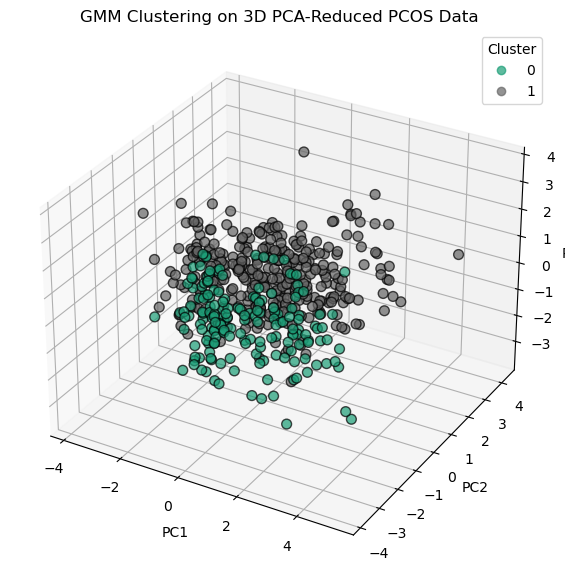

In [16]:
# Apply PCA for 3D projection
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_pcos)

# GMM clustering on 3D PCA data
gmm_3d = GaussianMixture(n_components=2, random_state=42)
clusters_3d = gmm_3d.fit_predict(X_pca_3d)

# Plot GMM clusters in 3D PCA-reduced space
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=clusters_3d, cmap='Dark2', edgecolor='k', s=50, alpha=0.7)
ax.set_title("GMM Clustering on 3D PCA-Reduced PCOS Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [1]:
# Final evaluation using neural network classifier for multiple feature combinations
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def evaluate_models(X_variants, y_true):
    results = []
    for name, X in X_variants.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
        clf = MLPClassifier(random_state=42, max_iter=500)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append((name, acc, f1))
    return pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])

# Example (fill X_variants and y_true based on Spotify or PCOS clustering results):
# results_df = evaluate_models(X_variants, y)
# display(results_df)

In [4]:
# MLP classifier accuracy & F1-score on PCOS dataset (Original, PCA, ICA, Cluster, Cluster+PCA)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

df = pd.read_csv("data/PCOS_infertility.csv")
df.drop(columns=["Patient File No.", "Sl. No"], inplace=True, errors='ignore')
df = df.select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df.drop(columns=["PCOS (Y/N)"], errors="ignore"))
y = df["PCOS (Y/N)"]

# Normalized version of X for chi2 only
X_nonneg = MinMaxScaler().fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_ica = FastICA(n_components=2, random_state=42).fit_transform(X_scaled)
X_chi2 = SelectKBest(chi2, k=2).fit_transform(X_nonneg, y)
X_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_scaled)
cluster_labels = KMeans(n_clusters=2, random_state=42).fit_predict(X_scaled)

models = {
    "Original Features": X_scaled,
    "PCA (2D)": X_pca,
    "ICA (2D)": X_ica,
    "Chi2 Features": X_chi2,
    "SVD (2D)": X_svd,
    "KMeans Cluster ID Only (PCA)": cluster_labels.reshape(-1, 1),
    "PCA + KMeans Cluster ID": np.concatenate([X_pca, cluster_labels.reshape(-1, 1)], axis=1),
}

result = []
for name, features in models.items():
    X_tr, X_te, y_tr, y_te = train_test_split(features, y, stratify=y, random_state=42)
    model = MLPClassifier(max_iter=300, random_state=42)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    result.append([name, "MLPClassifier", round(acc, 4), round(f1, 4)])

pcos_df = pd.DataFrame(result, columns=["Model", "Classifier", "Accuracy", "F1 Score"])
print(pcos_df)

/opt/anaconda3/envs/info6105/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                          Model     Classifier  Accuracy  F1 Score
0             Original Features  MLPClassifier    0.6765       0.0
1                      PCA (2D)  MLPClassifier    0.6765       0.0
2                      ICA (2D)  MLPClassifier    0.6765       0.0
3                 Chi2 Features  MLPClassifier    0.6765       0.0
4                      SVD (2D)  MLPClassifier    0.6765       0.0
5  KMeans Cluster ID Only (PCA)  MLPClassifier    0.6765       0.0
6       PCA + KMeans Cluster ID  MLPClassifier    0.6691       0.0
